In [ ]:
import numpy as np #Helps in data munipulation
import matplotlib.pyplot as plt #Helps in creating the plot
import seaborn as sns #Helps in data visulization
from dataclasses import dataclass #Helps to create the dataclass
from typing import List #Helps to import list type
import time #Helps to know the execution time
import warnings #Helps to supress the warning messages
from multiprocessing import Pool, cpu_count #Helps to create pool for parellel execution

# Basic Setup and Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Data Structures for the Grid

@dataclass
class GridNode:
    """Represents a consumption point in the grid."""
    id: int
    base_demand: float
    max_capacity: float
    transmission_loss: float
    demand: float = 0.0  # This will be updated each hour

@dataclass
class EnergySource:
    """Represents a power generation source."""
    id: int
    max_supply: float
    cost_per_mw: float
    availability: float # Factor (0 to 1) for reliability/downtime

# --- Data Preparation: Define the Grid and Demand Profile ---

# Defining a static grid with 10 nodes and 3 energy sources
NODES = [
    GridNode(id=i+1, base_demand=np.random.uniform(50, 150),
             max_capacity=200, transmission_loss=np.random.uniform(0.02, 0.1))
    for i in range(10)
]

SOURCES = [
    EnergySource(id=1, max_supply=500, cost_per_mw=20, availability=0.95), # Cheap, reliable base load (e.g., Nuclear/Hydro)
    EnergySource(id=2, max_supply=400, cost_per_mw=15, availability=0.70), # Cheapest, but less reliable (e.g., Wind/Solar)
    EnergySource(id=3, max_supply=300, cost_per_mw=45, availability=0.99), # Expensive, reliable peaker plant (e.g., Gas)
]

# Defining a 24-hour demand profile (simulates day/night cycle)
# This multiplier will be applied to the base demand of each node for each hour.
HOURLY_DEMAND_MULTIPLIER = 0.7 + 0.4 * np.sin(np.linspace(0, 2 * np.pi, 24)) + np.random.uniform(-0.05, 0.05, 24)

print("Data structures and grid configuration prepared.")
print(NODES)
print(SOURCES)

Data structures and grid configuration prepared.
[GridNode(id=1, base_demand=68.14282502024767, max_capacity=200, transmission_loss=0.09918659087247325, demand=0.0), GridNode(id=2, base_demand=126.71323976801256, max_capacity=200, transmission_loss=0.052666124176958456, demand=0.0), GridNode(id=3, base_demand=51.09798449498082, max_capacity=200, transmission_loss=0.053639021153102484, demand=0.0), GridNode(id=4, base_demand=98.2443533587871, max_capacity=200, transmission_loss=0.06790796043867534, demand=0.0), GridNode(id=5, base_demand=142.4402218247061, max_capacity=200, transmission_loss=0.09055308384899129, demand=0.0), GridNode(id=6, base_demand=114.63418845531102, max_capacity=200, transmission_loss=0.07018222207336275, demand=0.0), GridNode(id=7, base_demand=117.75931630294427, max_capacity=200, transmission_loss=0.05190869092853817, demand=0.0), GridNode(id=8, base_demand=143.69970123712176, max_capacity=200, transmission_loss=0.06467619129406596, demand=0.0), GridNode(id=9, ba

In [ ]:
# Preprocessing & Helper Functions

def create_cost_matrix(sources: List[EnergySource], nodes: List[GridNode]) -> np.ndarray:
    """
    Calculates the cost matrix, including a transmission loss penalty.
    This is a preprocessing step to avoid recalculating costs repeatedly.
    """
    cost_matrix = np.zeros((len(sources), len(nodes)))
    for i, source in enumerate(sources):
        for j, node in enumerate(nodes):
            # Simple model: effective_cost = source_cost * (1 + transmission_loss_factor)
            cost_matrix[i, j] = source.cost_per_mw * (1 + node.transmission_loss)
    return cost_matrix

print("Preprocessing functions defined.")

Preprocessing functions defined.



--- Performing Exploratory Data Analysis ---


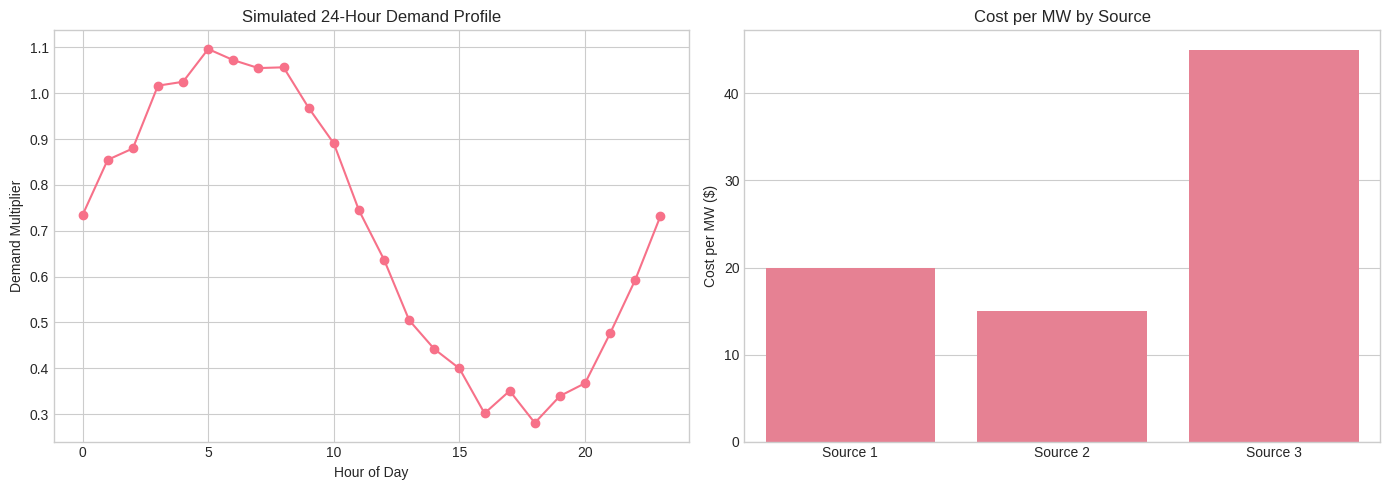

In [ ]:
# Exploratory Data Analysis (EDA)

def perform_eda(demand_multipliers, sources):
    """
    This is a placeholder for EDA. In a real project, you would
    visualize your input data to gain insights.
    """
    print("\n--- Performing Exploratory Data Analysis ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Visualize the 24-hour demand curve
    ax1.plot(np.arange(24), demand_multipliers, 'o-', label='Hourly Demand Multiplier')
    ax1.set_title('Simulated 24-Hour Demand Profile')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Demand Multiplier')
    ax1.grid(True)

    # 2. Visualize the cost vs. capacity of energy sources
    costs = [s.cost_per_mw for s in sources]
    capacities = [s.max_supply for s in sources]
    labels = [f'Source {s.id}' for s in sources]
    sns.barplot(x=labels, y=costs, ax=ax2)
    ax2.set_title('Cost per MW by Source')
    ax2.set_ylabel('Cost per MW ($)')

    plt.tight_layout()
    plt.show()

# Run the EDA on our prepared data
perform_eda(HOURLY_DEMAND_MULTIPLIER, SOURCES)

In [ ]:
# Genetic Algorithm Core Setup

def fitness_function(chromosome: np.ndarray, sources: List[EnergySource], nodes: List[GridNode], cost_matrix: np.ndarray) -> float:
    """
    Calculates the fitness of a single solution (chromosome).
    A lower score is better, representing lower total cost.
    Penalties are added for invalid solutions to guide the search.
    """
    allocation_matrix = chromosome.reshape(len(sources), len(nodes))

    # 1. Calculate the total generation cost
    total_cost = np.sum(allocation_matrix * cost_matrix)

    # 2. Define Penalties to guide the algorithm to valid solutions
    demand_penalty = 0
    supply_penalty = 0
    capacity_penalty = 0

    # Penalty for not meeting demand or exceeding node capacity
    for j, node in enumerate(nodes):
        power_delivered = np.sum(allocation_matrix[:, j])
        if power_delivered < node.demand:
            demand_penalty += (node.demand - power_delivered)**2 * 1000  # High penalty for unmet demand
        elif power_delivered > node.max_capacity:
            capacity_penalty += (power_delivered - node.max_capacity)**2 * 500

    # Penalty for exceeding source capacity (considering availability)
    for i, source in enumerate(sources):
        power_allocated = np.sum(allocation_matrix[i, :])
        max_available = source.max_supply * source.availability
        if power_allocated > max_available:
            supply_penalty += (power_allocated - max_available)**2 * 1000

    return total_cost + demand_penalty + supply_penalty + capacity_penalty

class BaseGeneticAlgorithm:
    """A base class containing shared logic for Serial and Parallel GAs."""
    def __init__(self, sources, nodes, population_size=100, mutation_rate=0.05, crossover_rate=0.8, elite_size=5):
        self.sources = sources
        self.nodes = nodes
        self.n_sources = len(sources)
        self.n_nodes = len(nodes)
        self.chromosome_length = self.n_sources * self.n_nodes
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elite_size = elite_size
        self.cost_matrix = create_cost_matrix(self.sources, self.nodes)

    def _create_chromosome(self):
        """Creates a random, flattened allocation matrix."""
        chromosome = np.random.rand(self.chromosome_length)
        total_demand = sum(n.demand for n in self.nodes)
        if np.sum(chromosome) > 0:
            chromosome = chromosome / np.sum(chromosome) * total_demand
        return chromosome

    def _create_initial_population(self):
        return [self._create_chromosome() for _ in range(self.population_size)]

    def _selection(self, population, fitness_scores):
        """Tournament selection: pick 3 random individuals, the best one wins."""
        selected_parents = []
        for _ in range(len(population)):
            tournament_indices = np.random.choice(len(population), 3, replace=False)
            winner_index = min(tournament_indices, key=lambda i: fitness_scores[i])
            selected_parents.append(population[winner_index])
        return np.array(selected_parents)

    def _crossover(self, parent1, parent2):
        """Single-point crossover."""
        if np.random.rand() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        point = np.random.randint(1, self.chromosome_length - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return child1, child2

    def _mutation(self, chromosome):
        """Gaussian mutation to make small adjustments."""
        for i in range(self.chromosome_length):
            if np.random.rand() < self.mutation_rate:
                mutation_value = np.random.normal(0, 0.1 * (chromosome[i] + 1e-3))
                chromosome[i] += mutation_value
                chromosome[i] = max(0, chromosome[i]) # Ensure power allocation is not negative
        return chromosome

print("Core Genetic Algorithm components defined.")

Core Genetic Algorithm components defined.


In [ ]:
# Serial GA Implementation

class SerialGeneticAlgorithm(BaseGeneticAlgorithm):
    """Runs the Genetic Algorithm sequentially."""
    def run(self, generations=100):
        population = self._create_initial_population()
        best_fitness_overall = float('inf')

        for gen in range(generations):
            # Fitness evaluation is done in a simple loop
            fitness_scores = [fitness_function(chrom, self.sources, self.nodes, self.cost_matrix) for chrom in population]

            best_fitness_gen = min(fitness_scores)
            if best_fitness_gen < best_fitness_overall:
                best_fitness_overall = best_fitness_gen

            # Elitism: carry over the best individuals to the next generation
            elite_indices = np.argsort(fitness_scores)[:self.elite_size]
            new_population = [population[i] for i in elite_indices]

            parents = self._selection(population, fitness_scores)

            # Create the rest of the new population through crossover and mutation
            while len(new_population) < self.population_size:
                p1, p2 = parents[np.random.choice(len(parents), 2, replace=False)]
                c1, c2 = self._crossover(p1, p2)
                new_population.append(self._mutation(c1))
                if len(new_population) < self.population_size:
                    new_population.append(self._mutation(c2))
            population = new_population
        return best_fitness_overall

print("Serial GA class defined.")

Serial GA class defined.


In [ ]:
# Parallel GA Implementation

def _evaluate_fitness_pool(args):
    """Helper function to unpack arguments for the pool.map, needed for multiprocessing."""
    return fitness_function(*args)

class ParallelGeneticAlgorithm(BaseGeneticAlgorithm):
    """Runs the Genetic Algorithm in parallel using multiprocessing."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # The pool of worker processes is created once during initialization
        self.pool = Pool(processes=cpu_count())
        print(f"Parallel GA initialized with {cpu_count()} worker processes.")

    def run(self, generations=100):
        population = self._create_initial_population()
        best_fitness_overall = float('inf')

        for gen in range(generations):
            # Prepare arguments for each chromosome to be evaluated
            args_for_pool = [(chrom, self.sources, self.nodes, self.cost_matrix) for chrom in population]

            # This is the key difference: map the fitness function across the process pool
            fitness_scores = self.pool.map(_evaluate_fitness_pool, args_for_pool)

            best_fitness_gen = min(fitness_scores)
            if best_fitness_gen < best_fitness_overall:
                best_fitness_overall = best_fitness_gen

            elite_indices = np.argsort(fitness_scores)[:self.elite_size]
            new_population = [population[i] for i in elite_indices]

            parents = self._selection(population, fitness_scores)

            while len(new_population) < self.population_size:
                p1, p2 = parents[np.random.choice(len(parents), 2, replace=False)]
                c1, c2 = self._crossover(p1, p2)
                new_population.append(self._mutation(c1))
                if len(new_population) < self.population_size:
                  new_population.append(self._mutation(c2))
            population = new_population
        return best_fitness_overall

    def close_pool(self):
        """Closes the worker pool. Important to call this when done."""
        self.pool.close()
        self.pool.join()

print("Parallel GA class defined.")

Parallel GA class defined.


In [ ]:
# Simulation Execution: Running and Comparing Algorithms

# A simple, fast but suboptimal algorithm for a baseline comparison
def greedy_algorithm(sources, nodes, cost_matrix):
    allocation = np.zeros((len(sources), len(nodes)))
    remaining_supply = np.array([s.max_supply * s.availability for s in sources])

    # Fulfill demand for each node one by one, using the cheapest available source first
    for j, node in enumerate(nodes):
        demand_to_meet = node.demand
        # Get indices of sources sorted by cost for this specific node
        source_indices = np.argsort(cost_matrix[:, j])
        for i in source_indices:
            can_supply = remaining_supply[i]
            supply_amount = min(demand_to_meet, can_supply)
            allocation[i, j] = supply_amount
            remaining_supply[i] -= supply_amount
            demand_to_meet -= supply_amount
            if demand_to_meet <= 0:
                break
    return fitness_function(allocation.flatten(), sources, nodes, cost_matrix)

# This check ensures the simulation only runs when the script is executed directly
if __name__ == '__main__':
    # --- GA Parameters ---
    POP_SIZE = 100
    GENERATIONS = 50

    # --- Result Storage ---
    serial_runtimes, parallel_runtimes = [], []
    serial_fitnesses, parallel_fitnesses, greedy_fitnesses = [], [], []

    print("\n--- Starting 24-Hour Grid Optimization Simulation ---")

    # Initialize the Parallel GA once to reuse the process pool, saving overhead
    parallel_ga = ParallelGeneticAlgorithm(SOURCES, NODES, population_size=POP_SIZE)

    for hour in range(24):
        print(f"\n--- Hour {hour:02d}:00 ---")

        # Update the demand for each node based on the hourly multiplier
        total_demand_hour = 0
        for node in NODES:
            node.demand = node.base_demand * HOURLY_DEMAND_MULTIPLIER[hour]
            total_demand_hour += node.demand
        print(f"Total Grid Demand: {total_demand_hour:.2f} MW")

        # --- Run Serial GA ---
        serial_ga = SerialGeneticAlgorithm(SOURCES, NODES, population_size=POP_SIZE)
        start_time = time.time()
        best_fitness_serial = serial_ga.run(generations=GENERATIONS)
        end_time = time.time()
        serial_runtimes.append(end_time - start_time)
        serial_fitnesses.append(best_fitness_serial)
        print(f"Serial GA   | Time: {serial_runtimes[-1]:.4f}s | Best Fitness: {best_fitness_serial:.2f}")

        # --- Run Parallel GA ---
        # Note: We reuse the 'parallel_ga' instance to avoid recreating the process pool
        start_time = time.time()
        best_fitness_parallel = parallel_ga.run(generations=GENERATIONS)
        end_time = time.time()
        parallel_runtimes.append(end_time - start_time)
        parallel_fitnesses.append(best_fitness_parallel)
        print(f"Parallel GA | Time: {parallel_runtimes[-1]:.4f}s | Best Fitness: {best_fitness_parallel:.2f}")

        # --- Run Greedy Algorithm for baseline ---
        cost_matrix = create_cost_matrix(SOURCES, NODES)
        greedy_fitness = greedy_algorithm(SOURCES, NODES, cost_matrix)
        greedy_fitnesses.append(greedy_fitness)

    #  closing the pool! This releases the processes.
    parallel_ga.close_pool()


--- Starting 24-Hour Grid Optimization Simulation ---
Parallel GA initialized with 2 worker processes.

--- Hour 00:00 ---
Total Grid Demand: 810.00 MW
Serial GA   | Time: 0.4854s | Best Fitness: 22331.37
Parallel GA | Time: 0.6381s | Best Fitness: 23607.11

--- Hour 01:00 ---
Total Grid Demand: 942.91 MW
Serial GA   | Time: 0.5813s | Best Fitness: 26251.17
Parallel GA | Time: 0.9829s | Best Fitness: 26067.20

--- Hour 02:00 ---
Total Grid Demand: 970.30 MW
Serial GA   | Time: 0.5780s | Best Fitness: 26858.44
Parallel GA | Time: 0.6834s | Best Fitness: 27285.66

--- Hour 03:00 ---
Total Grid Demand: 1121.42 MW
Serial GA   | Time: 0.4708s | Best Fitness: 410220.09
Parallel GA | Time: 0.6931s | Best Fitness: 405230.14

--- Hour 04:00 ---
Total Grid Demand: 1130.85 MW
Serial GA   | Time: 0.5196s | Best Fitness: 515264.71
Parallel GA | Time: 0.6825s | Best Fitness: 526632.43

--- Hour 05:00 ---
Total Grid Demand: 1209.66 MW
Serial GA   | Time: 0.4781s | Best Fitness: 1985744.96
Parallel G



--- SIMULATION COMPLETE: FINAL RESULTS ---
Total Serial Execution Time:   12.16 seconds
Total Parallel Execution Time: 17.18 seconds
Achieved Speedup: 0.71x


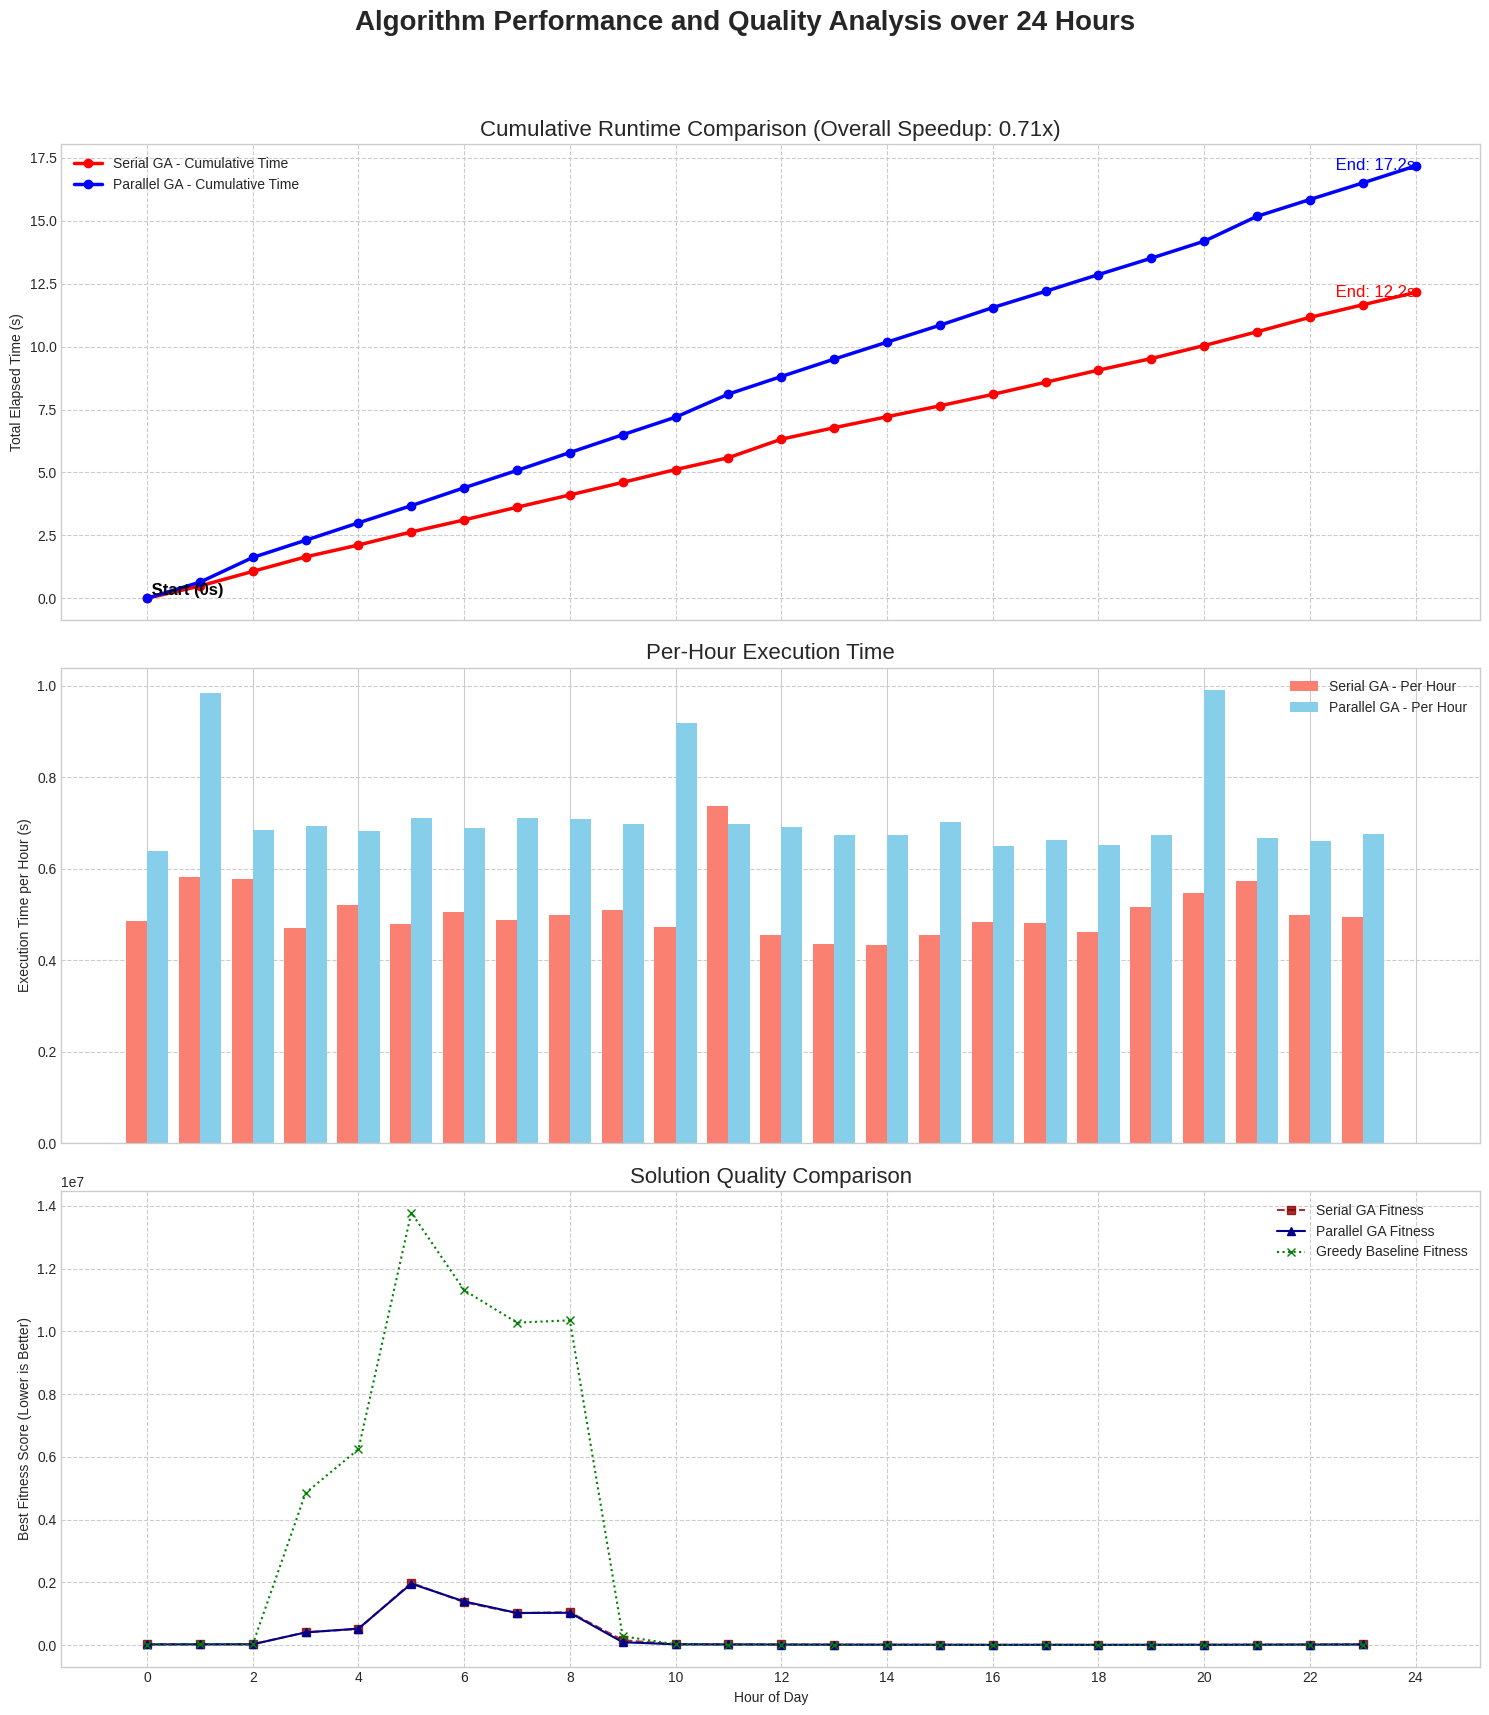

In [ ]:
# Performance Analysis and Visualization

if __name__ == '__main__':
    # Calculate final performance metrics
    total_serial_time = sum(serial_runtimes)
    total_parallel_time = sum(parallel_runtimes)
    # Speedup is the ratio of serial time to parallel time
    speedup = total_serial_time / total_parallel_time if total_parallel_time > 0 else float('inf')

    print("\n\n--- SIMULATION COMPLETE: FINAL RESULTS ---")
    print(f"Total Serial Execution Time:   {total_serial_time:.2f} seconds")
    print(f"Total Parallel Execution Time: {total_parallel_time:.2f} seconds")
    print(f"Achieved Speedup: {speedup:.2f}x")

    # --- Plotting ---
    hours = np.arange(24)
    # NEW: Create a new x-axis for the cumulative plot (from 0 to 24)
    cumulative_hours = np.arange(25)

    # NEW: Calculate the cumulative (running total) of runtimes
    # We use np.insert to add the starting point (0 seconds at hour 0)
    cumulative_serial_runtimes = np.insert(np.cumsum(serial_runtimes), 0, 0)
    cumulative_parallel_runtimes = np.insert(np.cumsum(parallel_runtimes), 0, 0)

    # --- Create Plots ---
    # We will now create 3 plots for better clarity
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
    fig.suptitle('Algorithm Performance and Quality Analysis over 24 Hours', fontsize=20, fontweight='bold')

    # --- Plot 1: Cumulative Runtime Comparison (with Start and End points) ---
    ax1.plot(cumulative_hours, cumulative_serial_runtimes, 'o-', label=f'Serial GA - Cumulative Time', color='red', linewidth=2.5)
    ax1.plot(cumulative_hours, cumulative_parallel_runtimes, 'o-', label=f'Parallel GA - Cumulative Time', color='blue', linewidth=2.5)

    # NEW: Add text annotations for start and end points
    ax1.text(0, 0, ' Start (0s)', ha='left', va='bottom', fontsize=12, color='black', fontweight='bold')
    ax1.text(24, total_serial_time, f' End: {total_serial_time:.1f}s', ha='right', va='center', fontsize=12, color='red')
    ax1.text(24, total_parallel_time, f' End: {total_parallel_time:.1f}s', ha='right', va='center', fontsize=12, color='blue')

    ax1.set_ylabel('Total Elapsed Time (s)')
    ax1.set_title(f'Cumulative Runtime Comparison (Overall Speedup: {speedup:.2f}x)', fontsize=16)
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--')

    # --- Plot 2: Per-Hour Runtime Comparison ---
    ax2.bar(hours - 0.2, serial_runtimes, width=0.4, label='Serial GA - Per Hour', color='salmon')
    ax2.bar(hours + 0.2, parallel_runtimes, width=0.4, label='Parallel GA - Per Hour', color='skyblue')
    ax2.set_ylabel('Execution Time per Hour (s)')
    ax2.set_title('Per-Hour Execution Time', fontsize=16)
    ax2.legend()
    ax2.grid(True, axis='y', linestyle='--')

    # --- Plot 3: Solution Quality (Fitness) Comparison ---
    ax3.plot(hours, serial_fitnesses, 's--', label='Serial GA Fitness', color='darkred', alpha=0.8)
    ax3.plot(hours, parallel_fitnesses, '^-', label='Parallel GA Fitness', color='darkblue')
    ax3.plot(hours, greedy_fitnesses, 'x:', label='Greedy Baseline Fitness', color='green')
    ax3.set_xlabel('Hour of Day')
    ax3.set_ylabel('Best Fitness Score (Lower is Better)')
    ax3.set_title('Solution Quality Comparison', fontsize=16)
    ax3.set_xticks(np.arange(0, 25, 2)) # Set x-axis ticks to be every 2 hours
    ax3.legend()
    ax3.grid(True, which='both', linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

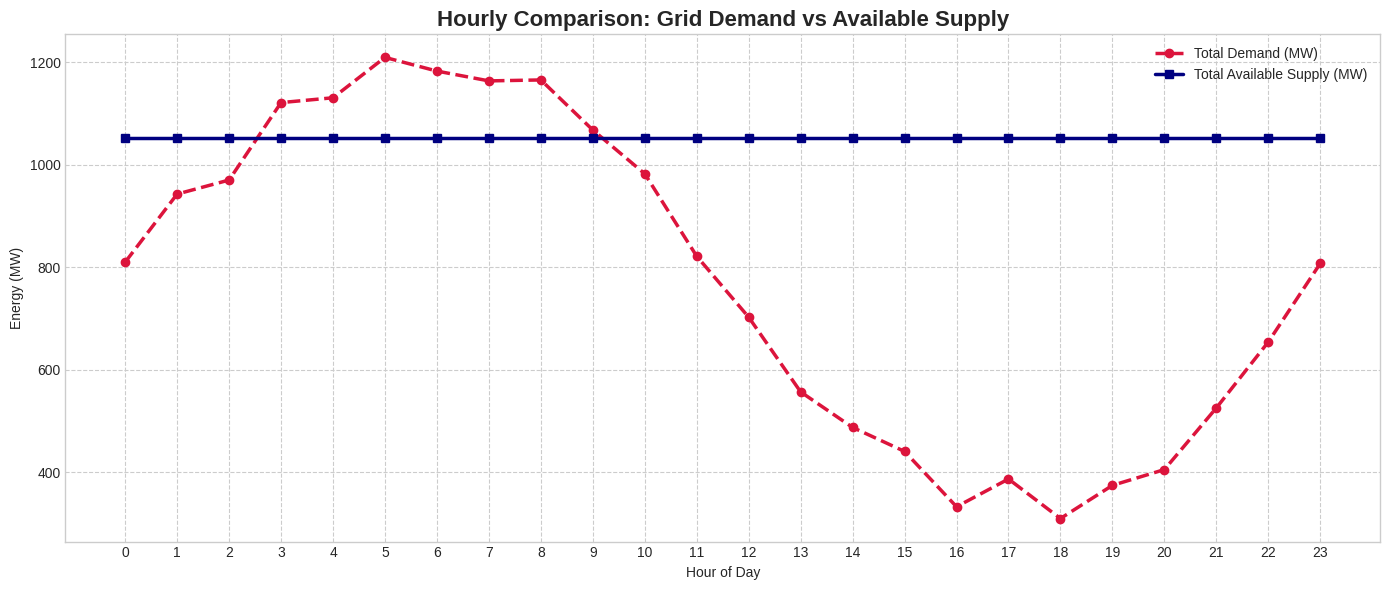

In [ ]:
 # Total Supply vs Demand Analysis
total_demands = []
total_supplies = []

for hour in range(24):
    # Calculate total demand at this hour
    demand = sum(n.base_demand * HOURLY_DEMAND_MULTIPLIER[hour] for n in NODES)
    total_demands.append(demand)

    # Calculate total available supply (availability * max_supply)
    supply = sum(s.max_supply * s.availability for s in SOURCES)
    total_supplies.append(supply)
    # --- Plot Supply vs Demand Comparison ---
fig, ax = plt.subplots(figsize=(14, 6))
hours = np.arange(24)

ax.plot(hours, total_demands, 'o--', label='Total Demand (MW)', color='crimson', linewidth=2.5)
ax.plot(hours, total_supplies, 's-', label='Total Available Supply (MW)', color='navy', linewidth=2.5)

ax.set_title('Hourly Comparison: Grid Demand vs Available Supply', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Energy (MW)')
ax.legend()
ax.grid(True, linestyle='--')
plt.xticks(np.arange(0, 24, 1))
plt.tight_layout()
plt.show()
